In [2]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

2.0.0+cu117

[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: python -m pip install --upgrade pip


In [3]:
# Load the graph data from a file
import pickle

with open('output/graph_data_for_god_component.pickle', 'rb') as file:
    G = pickle.load(file)

# Print nodes with their embedding
for node, embedding in G.nodes(data=True):
    print(f"Node: {node}, embedding: {embedding}")

Node: org.jfree.chart.plot.pie, embedding: {'NumberOfEntities': 7.0, 'NumberOfClasses': 7.0, 'NumberOfInterface': 0.0, 'LOC': 1699.0, 'AC': 4.0, 'EC': 5.0, 'Abstractness': 0.143, 'Instability': 0.556, 'NormalizedDistances': 0.301, 'WMC': 447.0, 'is_god_component': 0}
Node: org.jfree.data.gantt, embedding: {'NumberOfEntities': 6.0, 'NumberOfClasses': 5.0, 'NumberOfInterface': 1.0, 'LOC': 723.0, 'AC': 1.0, 'EC': 6.0, 'Abstractness': 0.167, 'Instability': 0.857, 'NormalizedDistances': 0.024, 'WMC': 222.0, 'is_god_component': 0}
Node: org.jfree.chart.internal, embedding: {'NumberOfEntities': 8.0, 'NumberOfClasses': 8.0, 'NumberOfInterface': 0.0, 'LOC': 898.0, 'AC': 264.0, 'EC': 2.0, 'Abstractness': 0.0, 'Instability': 0.008, 'NormalizedDistances': 0.992, 'WMC': 257.0, 'is_god_component': 0}
Node: org.jfree.chart.util, embedding: {'NumberOfEntities': 10.0, 'NumberOfClasses': 8.0, 'NumberOfInterface': 2.0, 'LOC': 558.0, 'AC': 27.0, 'EC': 4.0, 'Abstractness': 0.2, 'Instability': 0.129, 'Norma

In [4]:
import torch
from torch_geometric.data import Data

def networkx_to_pyg_data(graph):
    node_features_list = []
    labels = []
    node_mapping = {}
    node_index = 0

    for node, node_data in graph.nodes(data=True):
        node_mapping[node] = node_index
        features = [node_data['NumberOfEntities'], 
                    node_data['NumberOfClasses'], 
                    node_data['NumberOfInterface'], 
                    node_data['LOC'],
                    node_data['AC'],
                    node_data['EC'],
                    node_data['Abstractness'],
                    node_data['Instability'],
                    node_data['NormalizedDistances'],
                    node_data['WMC']]
        node_features_list.append(features)
        labels.append(node_data['is_god_component'])
        node_index += 1

    edge_index = []
    for source, target in graph.edges():
        edge_index.append([node_mapping[source], node_mapping[target]])
    
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    x = torch.tensor(node_features_list, dtype=torch.float)
    y = torch.tensor(labels, dtype=torch.long)

    return Data(x=x, edge_index=edge_index, y=y)

pyg_data = networkx_to_pyg_data(G)

In [5]:
def add_num_classes_to_pyg_data(data):
    num_classes = data.y.unique().size(0)
    data.num_classes = num_classes
    
add_num_classes_to_pyg_data(pyg_data)

print(f"Number of classes: {pyg_data.num_classes}")

Number of classes: 2


In [6]:
print(f'Dataset: {pyg_data}:')
print('======================')
print(f'Number of graphs: {len(pyg_data)}')
print(f'Number of features: {pyg_data.num_features}')
print(f'Number of classes: {pyg_data.num_classes}')
print(f'Number of nodes: {pyg_data.num_nodes}')
print(f'Number of edges: {pyg_data.num_edges}')
print(f'Average node degree: {pyg_data.num_edges / pyg_data.num_nodes:.2f}')
print(f'Has isolated nodes: {pyg_data.has_isolated_nodes()}')
print(f'Has self-loops: {pyg_data.has_self_loops()}')
print(f'Is undirected: {pyg_data.is_undirected()}')

Dataset: Data(x=[42, 10], edge_index=[2, 852], y=[42], num_classes=2):
Number of graphs: 4
Number of features: 10
Number of classes: 2
Number of nodes: 42
Number of edges: 852
Average node degree: 20.29
Has isolated nodes: False
Has self-loops: False
Is undirected: False


In [8]:
def save_pyg_dataset(dataset, file_path):
    torch.save(dataset, file_path)

# Assuming 'pyg_dataset' is the dataset you want to save
output_file_path = 'output/pyg_dataset_for_god_component.pt'
save_pyg_dataset(pyg_data, output_file_path)

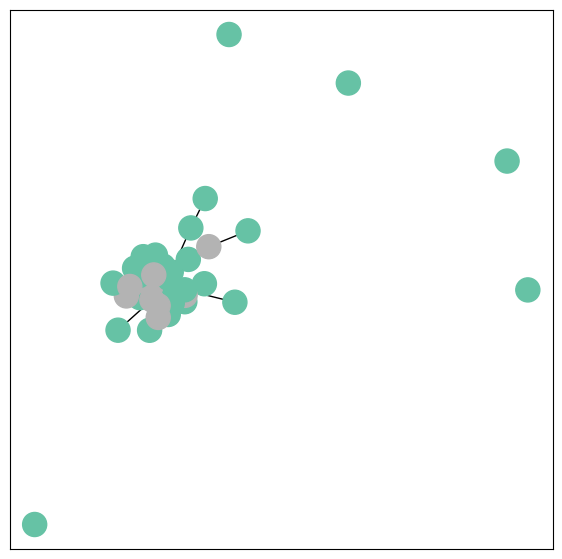

In [9]:
import networkx as nx
from torch_geometric.utils import to_networkx

def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()

G = to_networkx(pyg_data, to_undirected=True)
visualize_graph(G, color=pyg_data.y)

In [10]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(pyg_data.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, pyg_data.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        
        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(10, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=2, bias=True)
)


Embedding shape: [42, 2]


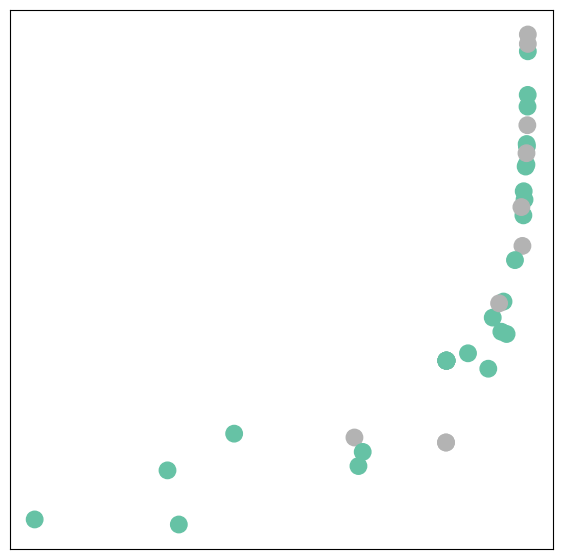

In [11]:
model = GCN()

_, h = model(pyg_data.x, pyg_data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

visualize_embedding(h, color=pyg_data.y)

In [12]:
import random

def add_train_mask_to_pyg_data(data, train_ratio=0.8):
    num_nodes = data.num_nodes
    num_train_nodes = int(train_ratio * num_nodes)

    # Generate a list of True and False values with the specified ratio
    mask_values = [True] * num_train_nodes + [False] * (num_nodes - num_train_nodes)

    # Randomly shuffle the mask values
    random.shuffle(mask_values)

    # Convert the mask_values list to a boolean tensor and assign it to the Data object
    data.train_mask = torch.tensor(mask_values, dtype=torch.bool)

# Example usage
add_train_mask_to_pyg_data(pyg_data, train_ratio=0.8)

print(f"Train mask: {pyg_data.train_mask}")


Train mask: tensor([ True,  True,  True,  True,  True,  True,  True,  True, False,  True,
         True, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False,  True,  True,  True,  True,  True,
        False,  True, False,  True,  True,  True, False,  True, False,  True,
        False, False])


<IPython.core.display.Javascript object>

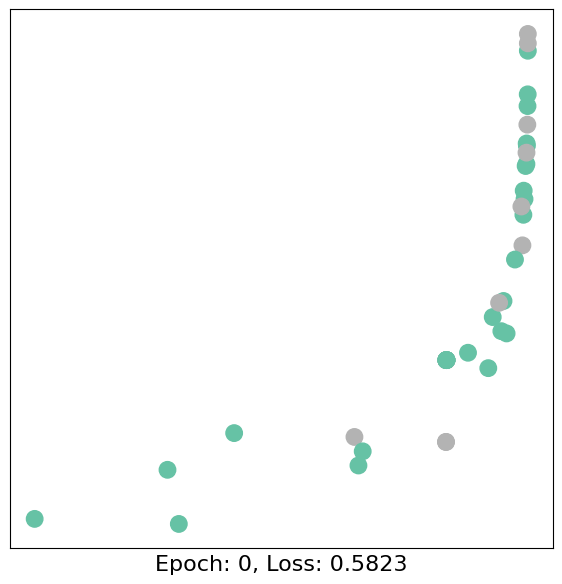

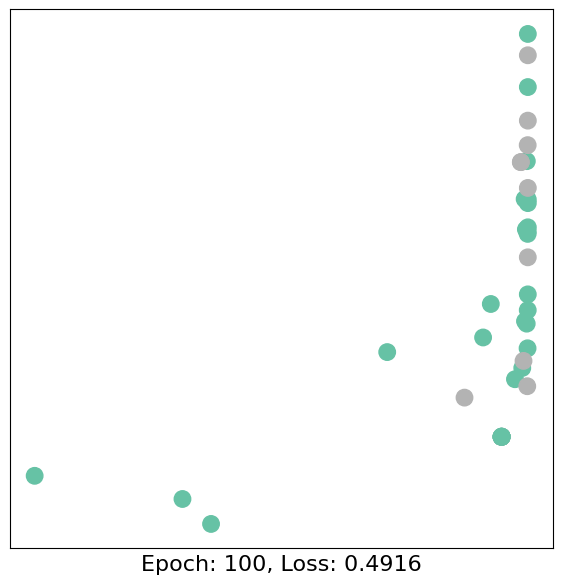

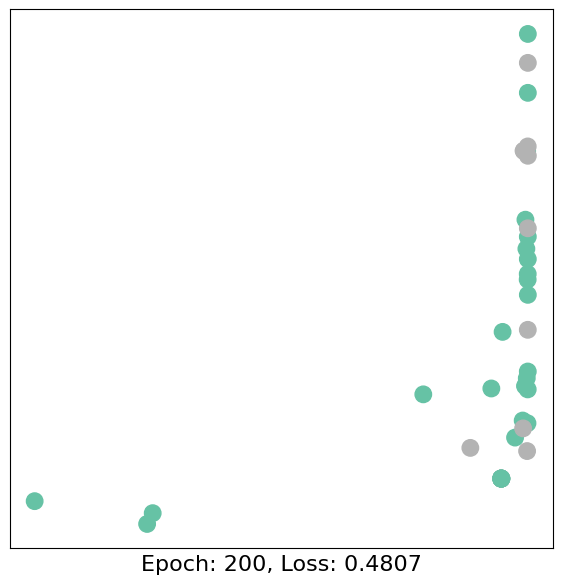

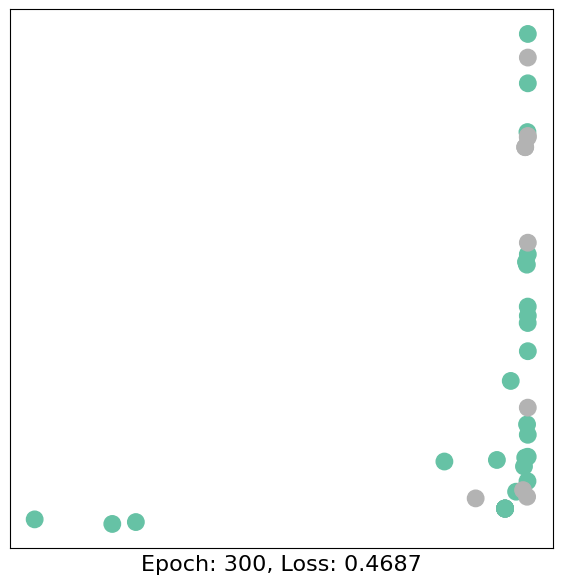

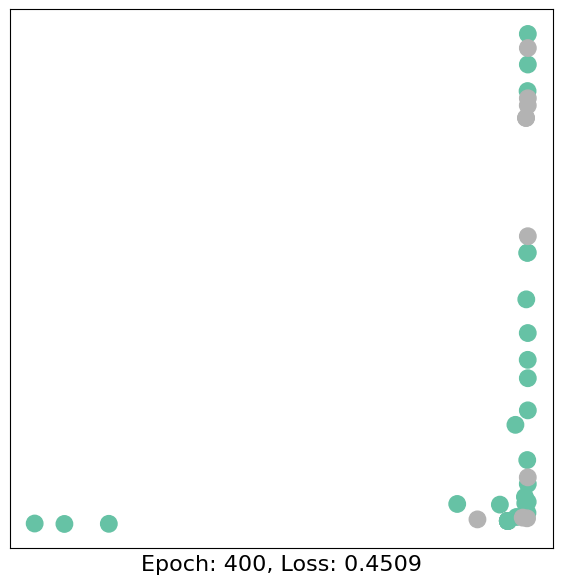

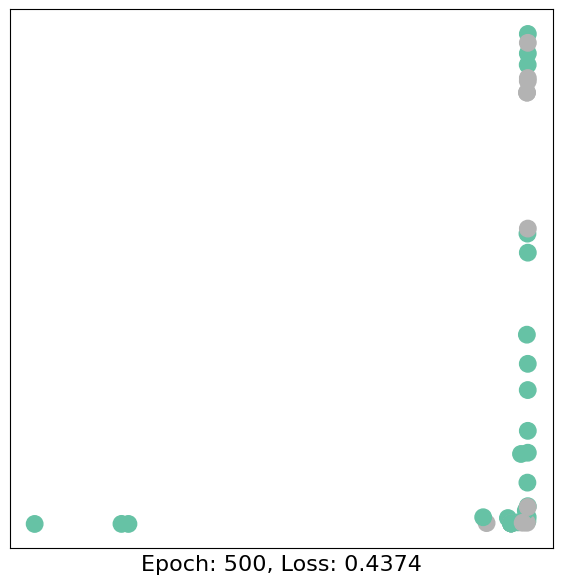

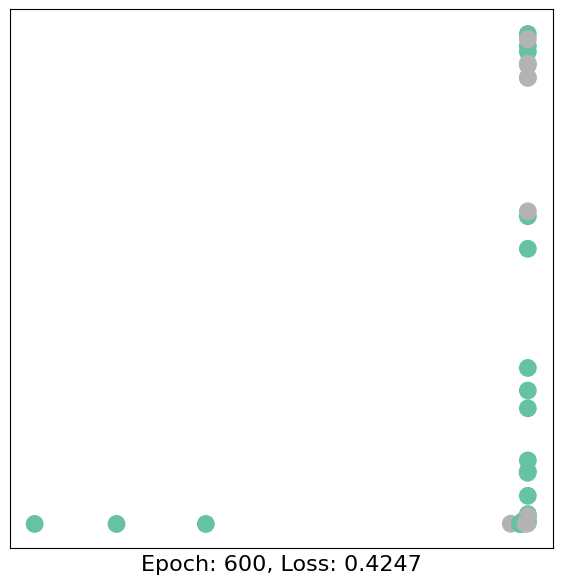

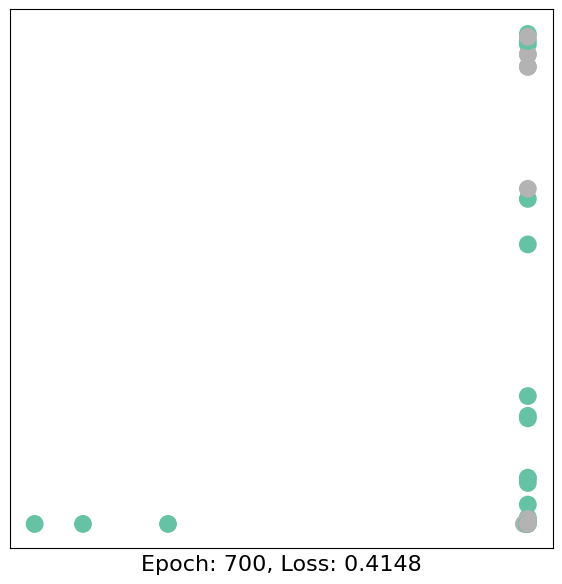

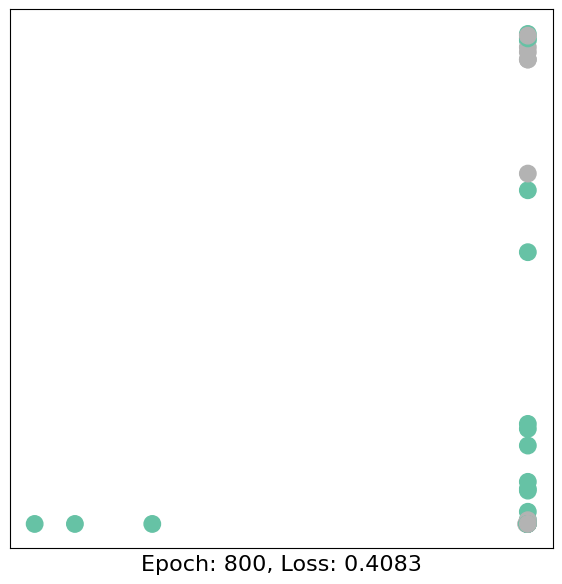

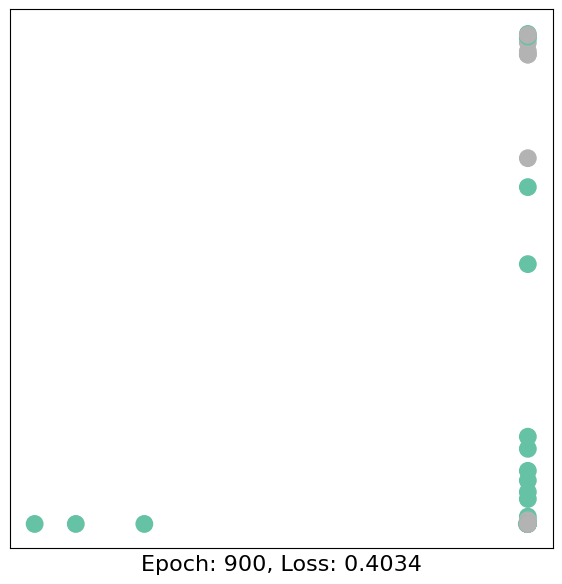

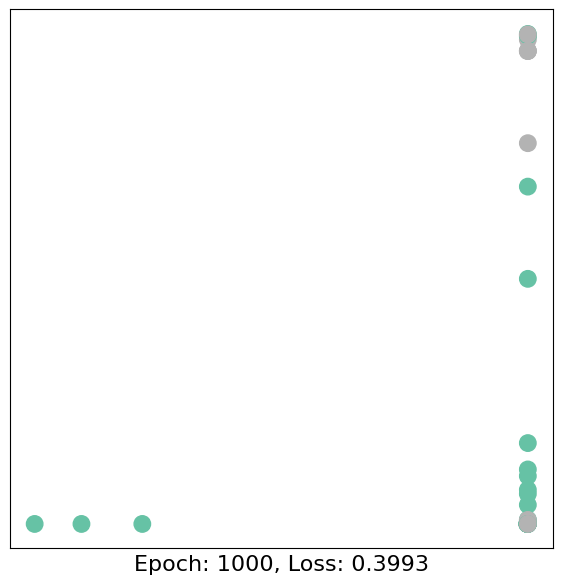

In [13]:
import time
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

model = GCN()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h

for epoch in range(1001):
    loss, h = train(pyg_data)
    if epoch % 100 == 0:
        visualize_embedding(h, color=pyg_data.y, epoch=epoch, loss=loss)
        time.sleep(0.3)

In [14]:
def add_test_mask_to_pyg_data(data):
    # If the train_mask is not set, raise an exception
    if not hasattr(data, 'train_mask'):
        raise ValueError("Please add a train_mask to the Data object first.")
    
    # Create a test mask as the complement of the train mask
    data.test_mask = ~data.train_mask

add_test_mask_to_pyg_data(pyg_data)

print(f"Test mask: {pyg_data.test_mask}")

Test mask: tensor([False, False, False, False, False, False, False, False,  True, False,
        False,  True, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
         True, False,  True, False, False, False,  True, False,  True, False,
         True,  True])


In [15]:
def evaluate(model, data):
    model.eval()
    with torch.no_grad():
        pred = model(data.x, data.edge_index)

        # Convert logits to class labels
        pred_labels = pred[0].argmax(dim=1)

        correct = (pred_labels[data.test_mask] == data.y[data.test_mask]).sum()
        acc = int(correct) / int(data.test_mask.sum())
        print(f'Accuracy: {acc:.4f}')

# Example usage
evaluate(model, pyg_data)

Accuracy: 0.6667
